In [2]:
import sys
import torch
import lightning as L
import glob
import numpy as np
import random
import matplotlib.pyplot as plt

sys.path.append("/home/szhang16/unet")
from models import LightningModel
from abidatamodule import AbiChipDataset

BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 14
LEARNING_RATE = 1e-4
TRAINING_SPLIT = 0.8
EPOCHS = 100
DATALOADER_WORKERS = 71

/panfs/ccds02/app/modules/miniforge/platform/x86_64/rhel/8.10/24.9.0/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
satmodel = LightningModel.load_from_checkpoint("/explore/nobackup/people/szhang16/checkpoints/satfull/best-epoch=28-val_loss=0.35.ckpt",
    model_name="SatVisionUNet", in_channels=IMG_CHANNELS, num_classes=1, lr=LEARNING_RATE, freeze_encoder=True, final_size=(91, 40)
)
unetmodel = LightningModel.load_from_checkpoint("/explore/nobackup/people/szhang16/checkpoints/unetfull/best-epoch=41-val_loss=0.35.ckpt", model_name="UNet", in_channels=IMG_CHANNELS, num_classes=1, lr=LEARNING_RATE, freeze_encoder=False)

=> merge config from /home/szhang16/.cache/huggingface/hub/models--nasa-cisto-data-science-group--satvision-toa-giant-patch8-window8-128/snapshots/ba822b094db803110d38c35aed889cf65689eef5/mim_pretrain_swinv2_satvision_giant_128_window08_50ep.yaml


/panfs/ccds02/app/modules/miniforge/platform/x86_64/rhel/8.10/24.9.0/envs/torch/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
chip_sample = random.sample(glob.glob("/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/GOES-16/*.npz"), 10)

dataset = AbiChipDataset(chip_sample)

/explore/nobackup/people/szhang16/.nccstmp/ipykernel_3302062/1337468240.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(dataset[i]['chip'].unsqueeze(0)).cuda()


TypeError: 'Text' object is not callable

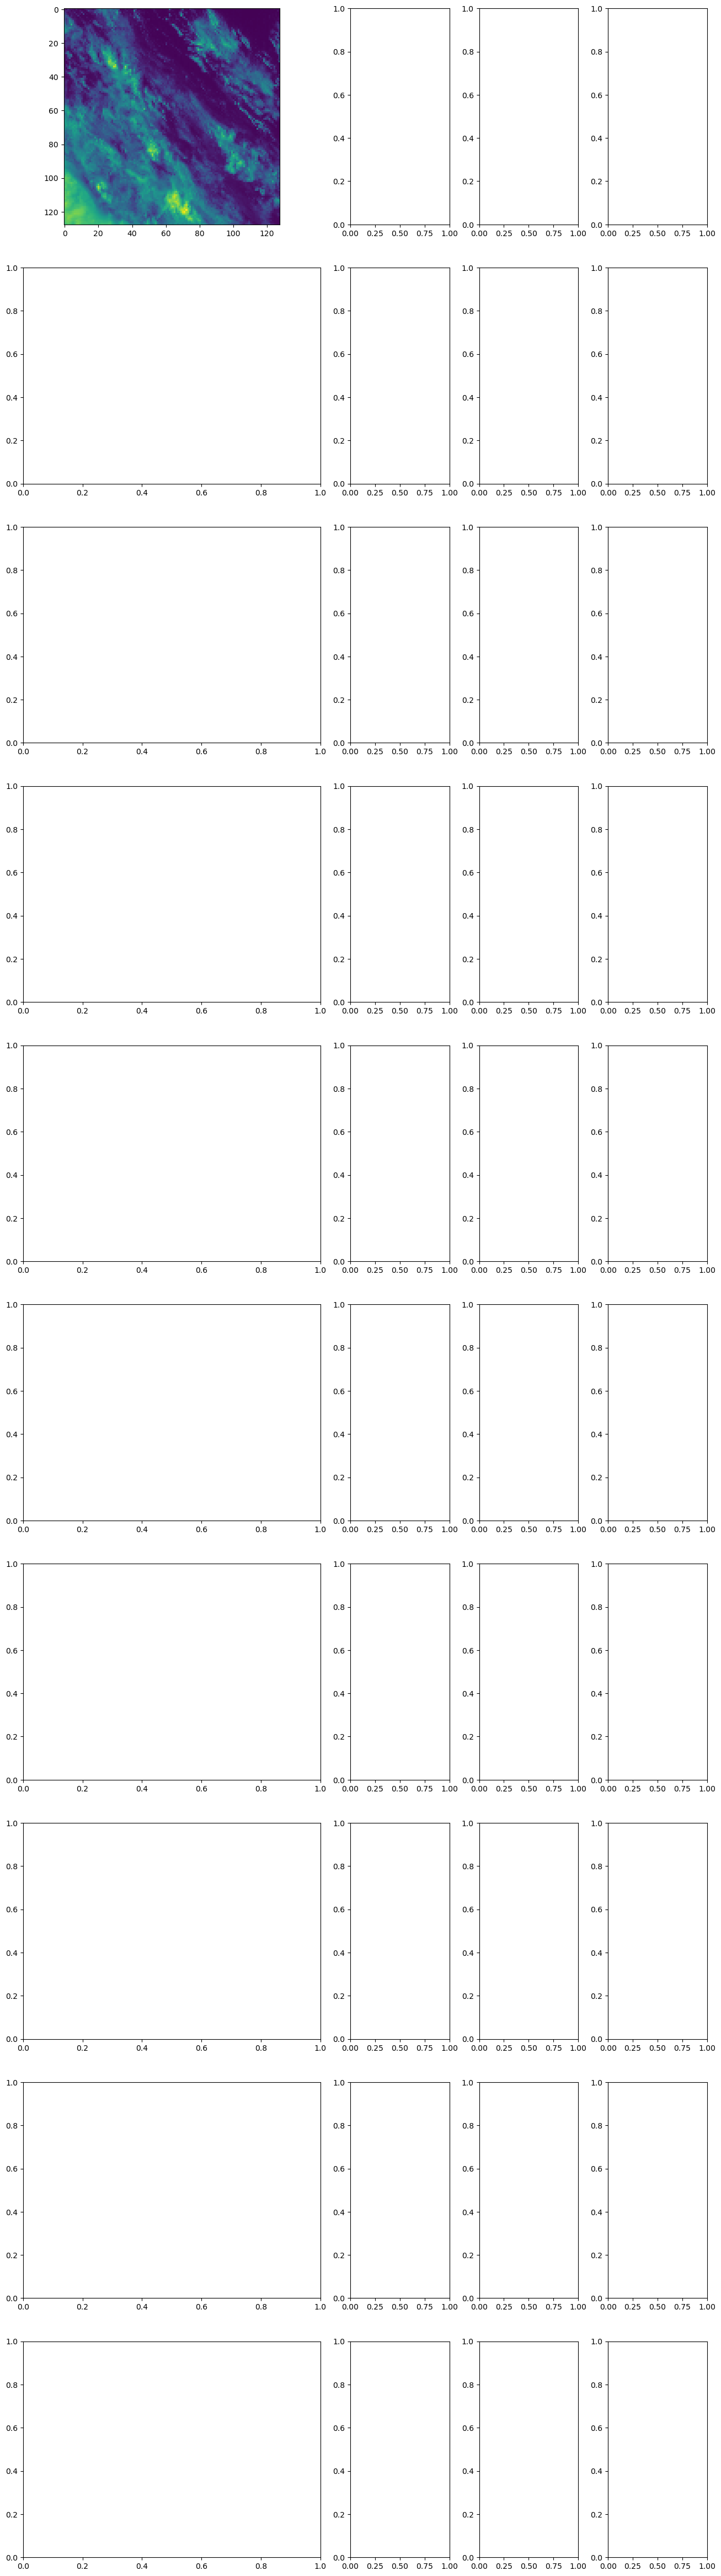

In [31]:
fig, axs = plt.subplots(10, 4, figsize=(16, 60), gridspec_kw={'width_ratios': [3, 1, 1, 1]})
for i in range(10):
    inputs = torch.tensor(dataset[i]['chip'].unsqueeze(0)).cuda()
    satpred = (torch.sigmoid(satmodel(inputs)) > 0.5).cpu().detach().numpy()
    unetpred = (torch.sigmoid(unetmodel(inputs)) > 0.5).cpu().detach().numpy()
    axs[i, 0].imshow(dataset[i]['chip'][0, :, :])
    axs[i, 0].title("ABI Chip")
    axs[i, 1].imshow(dataset[i]['mask'].squeeze())
    axs[i, 1].title("Ground Truth")
    axs[i, 2].imshow(satpred.squeeze())
    axs[i, 2].title("SatVision Prediction")
    axs[i, 3].imshow(unetpred.squeeze())
    axs[i, 3].title("UNet Prediction")